In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

# FUSE Client

1 server and 2 clients

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_delta(files):
    r = []; o = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)       
            r.append(to_seconds(data['delta']))
            try:
                o.append(float(data['stdout']))
            except:
                o.append(0)
    return r, o

SystemExit: Create time series (../results-paper/nojournal-cache/tmp/handle_client_request_tput.wsp.out) does not exist, please cd to experiments/baseline-interfere/results-paper/nojournal-cache and run ./plot.sh

To exit: use 'exit', 'quit', or Ctrl-D.


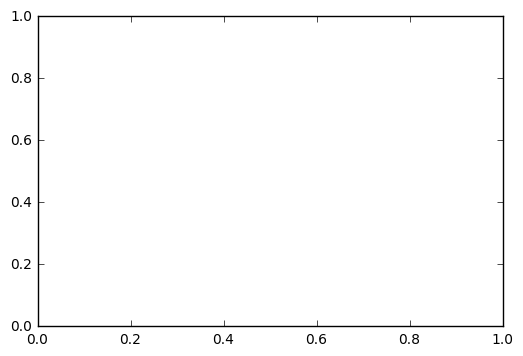

In [5]:
fig, ax = plt.subplots(1, 1)
s = '../results-paper/nojournal-cache/tmp/'

fname = s + 'handle_client_request_tput.wsp.out'
try:
    df = pd.read_csv(fname, skiprows=13, names=["index", "time",'handle_client_request_tput'])
except:
    sys.exit("Create time series (" + fname + ") does not exist, "+
             "please cd to experiments/baseline-interfere/results-paper/nojournal-cache and run ./plot.sh")    
    
df = df[df['time'] != 0]                  # filter out null timestamps
init = 0
if init == 0:
    init = float(df['time'].loc[0])       # beginning of runs shifted to 0 (unix time stamp)
#df = df.drop(df.index[range(0, 50)])     # drop some values to line up start times
shft = df['index'].iloc[0]                # shift timestamps to 0
df['x'] = df['time'] - init - shft        # specify values for x axis
df.plot(ax=ax, x='x', y='handle_client_request_tput', lw=4, label='interfere')
df1 = df
df1['x'] = df['x'] - 300
df1['handle_client_request_tput'] = df1['handle_client_request_tput'] - 0
df1.plot(ax=ax, x='x', y='handle_client_request_tput', lw=4, label='isolated')
ax.set_yticklabels(['', '', '1K', '', '2K', '', ''])
ax.set_title('Effect of Interfering Client')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Requests/sec')
ax.set_ylim(0, 3000)
ax.legend(loc='upper left', fontsize=12)

ax2 = ax.twinx()
("req_lookup", 3, 300, 210000)
df = pd.read_csv(s + 'req_lookup.wsp.out', skiprows=13, names=["index", "time", 'req_lookup'])
df = df[df['time'] != 0]                  # filter out null timestamps
shft = df['index'].iloc[0]                # shift timestamps to 0
df['x'] = df['time'] - init - shft        # specify values for x axis
df.plot(ax=ax2, x='x', y='req_lookup', marker='.', ms=10, lw=2, label='interfere (y2 axis)')

df1 = df
df1['x'] = df['x'] - 300
df1['req_lookup'] = df1['req_lookup'] - 210000
df1.plot(ax=ax2, x='x', y='req_lookup', marker='.', ms=10, lw=2, label='isolated (y2 axis)')

ax2.legend(loc='upper right', fontsize=12)
ax2.set_ylabel('# of Lookup Requests')
ax2.set_xlim(1, 199) 
ax2.set_ylim(1, 200000)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in vals])
ax2.set_yticklabels(['', '50K', '100K', '150K', ''])


# add arrow
ax.annotate('2nd Client Starts', fontsize=15, xy=(50, 1000), xytext=(10, 1800),
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='middle',
            )
fig.savefig('graphs/behavior-interfere.png', bbox_inches='tight', dpi=400)